# 3. EDA

# Prepare data - Jan 2015

In [30]:
# import libraries
import numpy as np
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

In [2]:
# Function to retrieve data from postgis as geo df using queries
def get_gdf(query, geom):
    # Connect to the database
    con =  psycopg2.connect(dbname='carto', user='carto', password='carto',
                            host='postgis', port='5432')

    # Save the query result as a geodataframe
    gdf = gpd.read_postgis(query, con, geom_col=geom)
    con.close()
    return gdf

In [3]:
# Query to select only 10,000 pickup data from January
q_jan = '''
        with
        
            jan as
            (
                select
                    tpep_pickup_datetime as pickup_time,
                    ST_SetSRID(ST_MakePoint(pickup_longitude, pickup_latitude), 4326) as pickup_point
                from taxi_jan
            )
        
        select jan.*
        from jan, census_blocks as census
        where ST_Contains(census.geometry, jan.pickup_point)
        LIMIT 10000;
        '''

# Save the query result as a geodataframe
pickup_jan = get_gdf(q_jan, 'pickup_point')
pickup_jan.head()

,pickup_time,pickup_point
0,2015-01-22 09:56:23,POINT (-73.95909 40.76241)
1,2015-01-22 09:56:23,POINT (-74.00178 40.74070)
2,2015-01-22 09:56:23,POINT (-73.97903 40.74065)
3,2015-01-22 09:56:23,POINT (-74.00726 40.73377)
4,2015-01-22 09:56:23,POINT (-73.95278 40.78647)


In [4]:
pickup_jan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pickup_time   10000 non-null  datetime64[ns]
 1   pickup_point  10000 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1)
memory usage: 156.4 KB


In [5]:
# Remove missing values if exist
pickup_jan = pickup_jan[~pickup_jan.isnull()]
pickup_jan.shape

(10000, 2)

In [6]:
# Remove duplicated rows
pickup_jan = pickup_jan[~pickup_jan.duplicated()]
pickup_jan.shape

(9993, 2)

In [7]:
# Print CRS
print(pickup_jan.crs)

epsg:4326


# More data

* demographic & socio-economic data
* census block group geometries

In [8]:
# Read the demographic and socio-economic data (by block group)
# from the American Community Survey (ACS) dataset
demographic = pd.read_csv('../data/nyc_acs_demographics.csv', index_col=0)
print(demographic.shape)
demographic.head()

(199630, 3)


,geoid,acs_demog_var,value
0,360050001001,total_pop,7080.0
1,360050001001,two_or_more_races_pop,41.0
2,360050001001,vacant_housing_units_for_rent,0.0
3,360050001001,unemployed_pop,0.0
4,360050001001,black_pop,3984.0


In [9]:
# Missing or duplicated values?
print(f'How many rows with missing values?: {demographic.isnull().any().sum()}')
print(f'How many duplicated rows?: {demographic.duplicated().sum()}')

How many rows with missing values?: 0
How many duplicated rows?: 0


In [10]:
# NYC census block group geometries
census = gpd.read_file('../data/nyc_cbg_geoms.geojson')
print(census.crs)
census.head()

epsg:4326


,geoid,geometry
0,360050001001,"POLYGON ((-73.89277 40.79284, -73.89261 40.792..."
1,360050002001,"POLYGON ((-73.86285 40.81267, -73.86191 40.812..."
2,360050002002,"POLYGON ((-73.86708 40.81444, -73.86332 40.812..."
3,360050002003,"POLYGON ((-73.85856 40.80665, -73.85848 40.806..."
4,360050004001,"POLYGON ((-73.85972 40.81527, -73.85956 40.815..."


In [11]:
# Missing or duplicated values?
print(f'How many rows with missing values?: {census.isnull().any().sum()}')
print(f'How many duplicated rows?: {census.duplicated().sum()}')

How many rows with missing values?: 0
How many duplicated rows?: 0


In [12]:
census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geoid     6339 non-null   object  
 1   geometry  6339 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 99.2+ KB


In [13]:
# Change the data type of 'geoid' column
# object -> numeric
census.geoid = pd.to_numeric(census.geoid)
census.geoid.dtype

dtype('int64')

# Visualize the data

In [14]:
# Reproject data in Web mercator
pickup_jan = pickup_jan.to_crs(epsg=3857)
census = census.to_crs(epsg=3857)

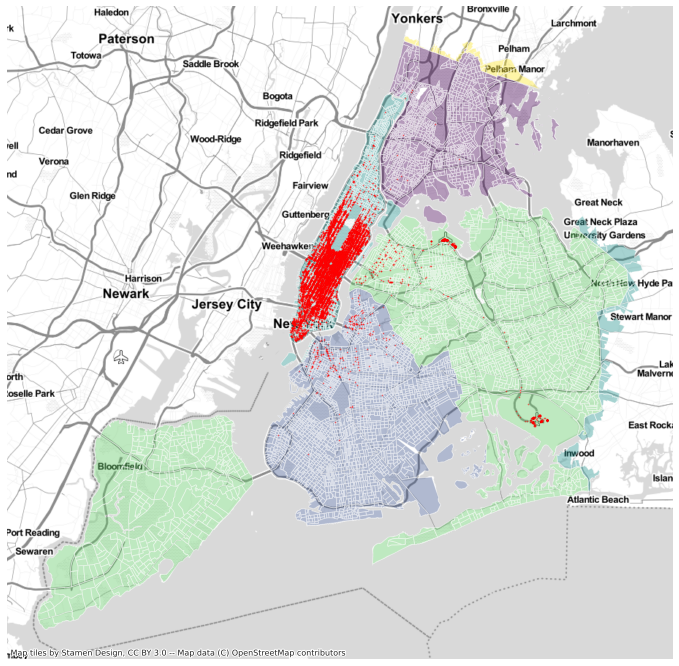

In [15]:
# Plot the census blocks
ax = census.plot(column = 'geoid', figsize=(12, 12), scheme='EqualInterval', alpha=.4, cmap='viridis')

# Plot pickup points within blocks (red points)
pickup_jan.plot(ax=ax, color='red', alpha=.4, markersize=.6)

# Basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

ax.set_axis_off()
plt.show()

# simpe EDA to understand the data

In [17]:
# Spatial join
pickup_blocks = gpd.sjoin(census, pickup_jan, how='inner', op='intersects')
print(pickup_blocks.shape)
pickup_blocks.head()

(9993, 4)


,geoid,geometry,index_right,pickup_time
51,360050039002,"POLYGON ((-8229309.164 4984364.326, -8229058.0...",6362,2015-01-10 03:51:02
124,360050065004,"POLYGON ((-8229043.779 4985443.634, -8228995.8...",6974,2015-01-19 05:52:36
134,360050069001,"POLYGON ((-8228280.572 4985853.591, -8228098.2...",5267,2015-01-01 23:24:07
145,360050072003,"POLYGON ((-8222231.805 4987738.555, -8222191.6...",5473,2015-01-24 02:18:02
172,360050079006,"POLYGON ((-8227409.831 4985244.325, -8227306.7...",1580,2015-01-18 00:12:49


<AxesSubplot:>

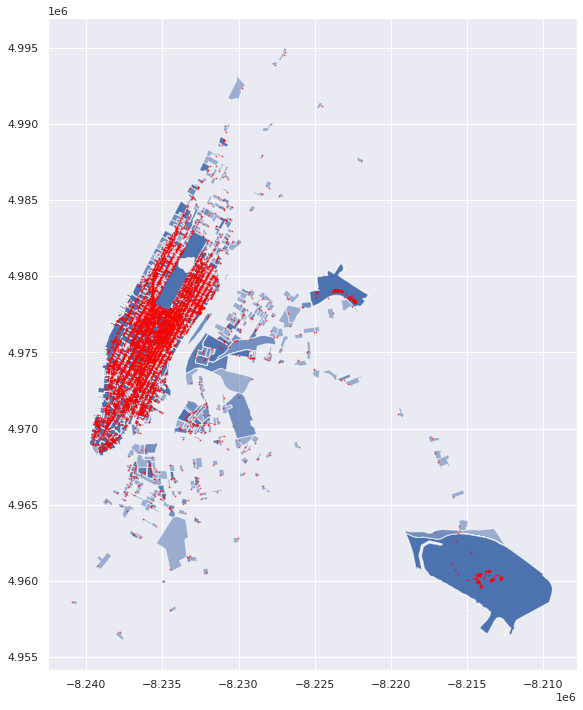

In [18]:
# Visualize the polygons only joined with the points
ax = pickup_blocks.plot(figsize=(12,12), alpha=.5)
pickup_jan.plot(ax=ax, color='red', alpha=.5, markersize=1)

In [19]:
# Count how many pickups were made within each block
pickup_blocks.geoid.value_counts()

360610101001    249
360810331001    199
360810716001    196
360610092001    164
360610143001    126
               ... 
360470190003      1
360470031003      1
360610224003      1
360470009001      1
360470033002      1
Name: geoid, Length: 1029, dtype: int64

In [41]:
# Pickups at each block group by weekday
pickup_blocks.groupby('geoid').pickup_time

DataError: No numeric types to aggregate